In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import datetime
from astropy import units as u
import scopesim as sim
import scopesim_templates as sim_tp
import astropy.units as u
from scopesim.effects.ter_curves import FilterCurve

In [2]:
src = sim_tp.micado.cluster()

imf - sample_imf: Setting maximum allowed mass to 10000
imf - sample_imf: Loop 0 added 1.01e+04 Msun to previous total of 0.00e+00 Msun


In [28]:
cmd = sim.UserCommands(
    use_instrument="MICADO",
    set_modes=["SCAO", "IMG_4mas"],
)
cmd.update(properties={
    "!OBS.filter_name_fw1": "J_DREAMS",
    "!OBS.filter_name_fw2": "open",
    "!OBS.ndit": 1, 
    "!OBS.dit": 3600,

    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0),

    # "!INST.filter_file_format": "filters/{}.dat",
})
micado = sim.OpticalTrain(cmd)
micado["MICADO_DET"]["detector_window"].include = False
micado["MICADO_DET"]["full_detector_array"].include = True
    

In [29]:
micado.observe(src)
hdus = micado.readout()

 Image Plane effects: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 14463.12it/s]

astar.scopesim.detector.detector_array - Extracting from 6 detectors...


In [24]:
filter_J_MICADO = FilterCurve(filename="filters/TC_filter_J.dat")
filter_J_DREAMS = FilterCurve(filename="filters/TC_filter_J_DREAMS.dat")

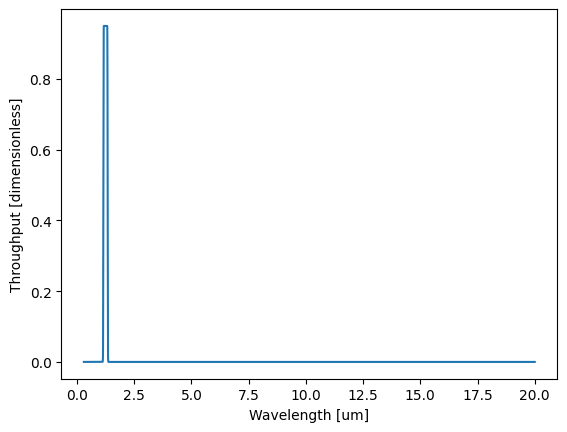

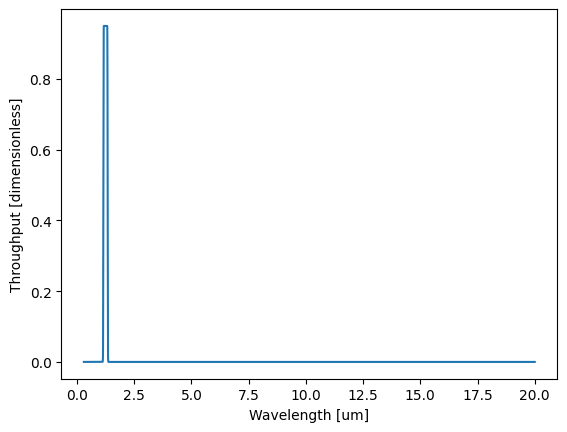

In [25]:
filter_J_MICADO.plot()

astar.scopesim.effects.ter_curves - WARNING: wavelength units in the meta dict of {'untitled filter'} are inconsistent:
- wavelength_unit : angstrom
- wave_unit : um


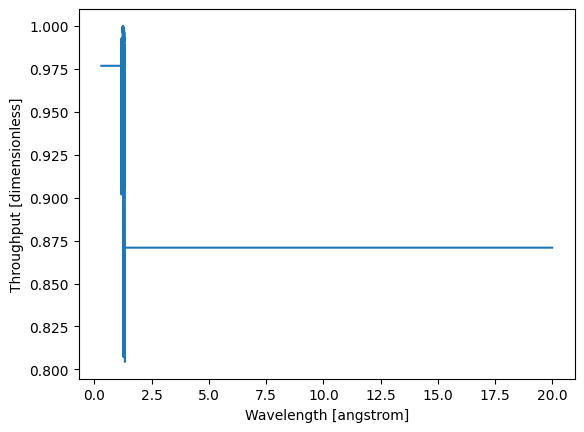

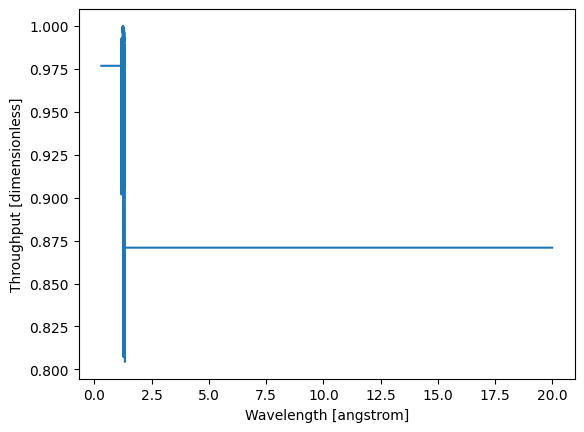

In [27]:
filter_J_DREAMS.plot()

In [30]:
len(hdus[0])

7

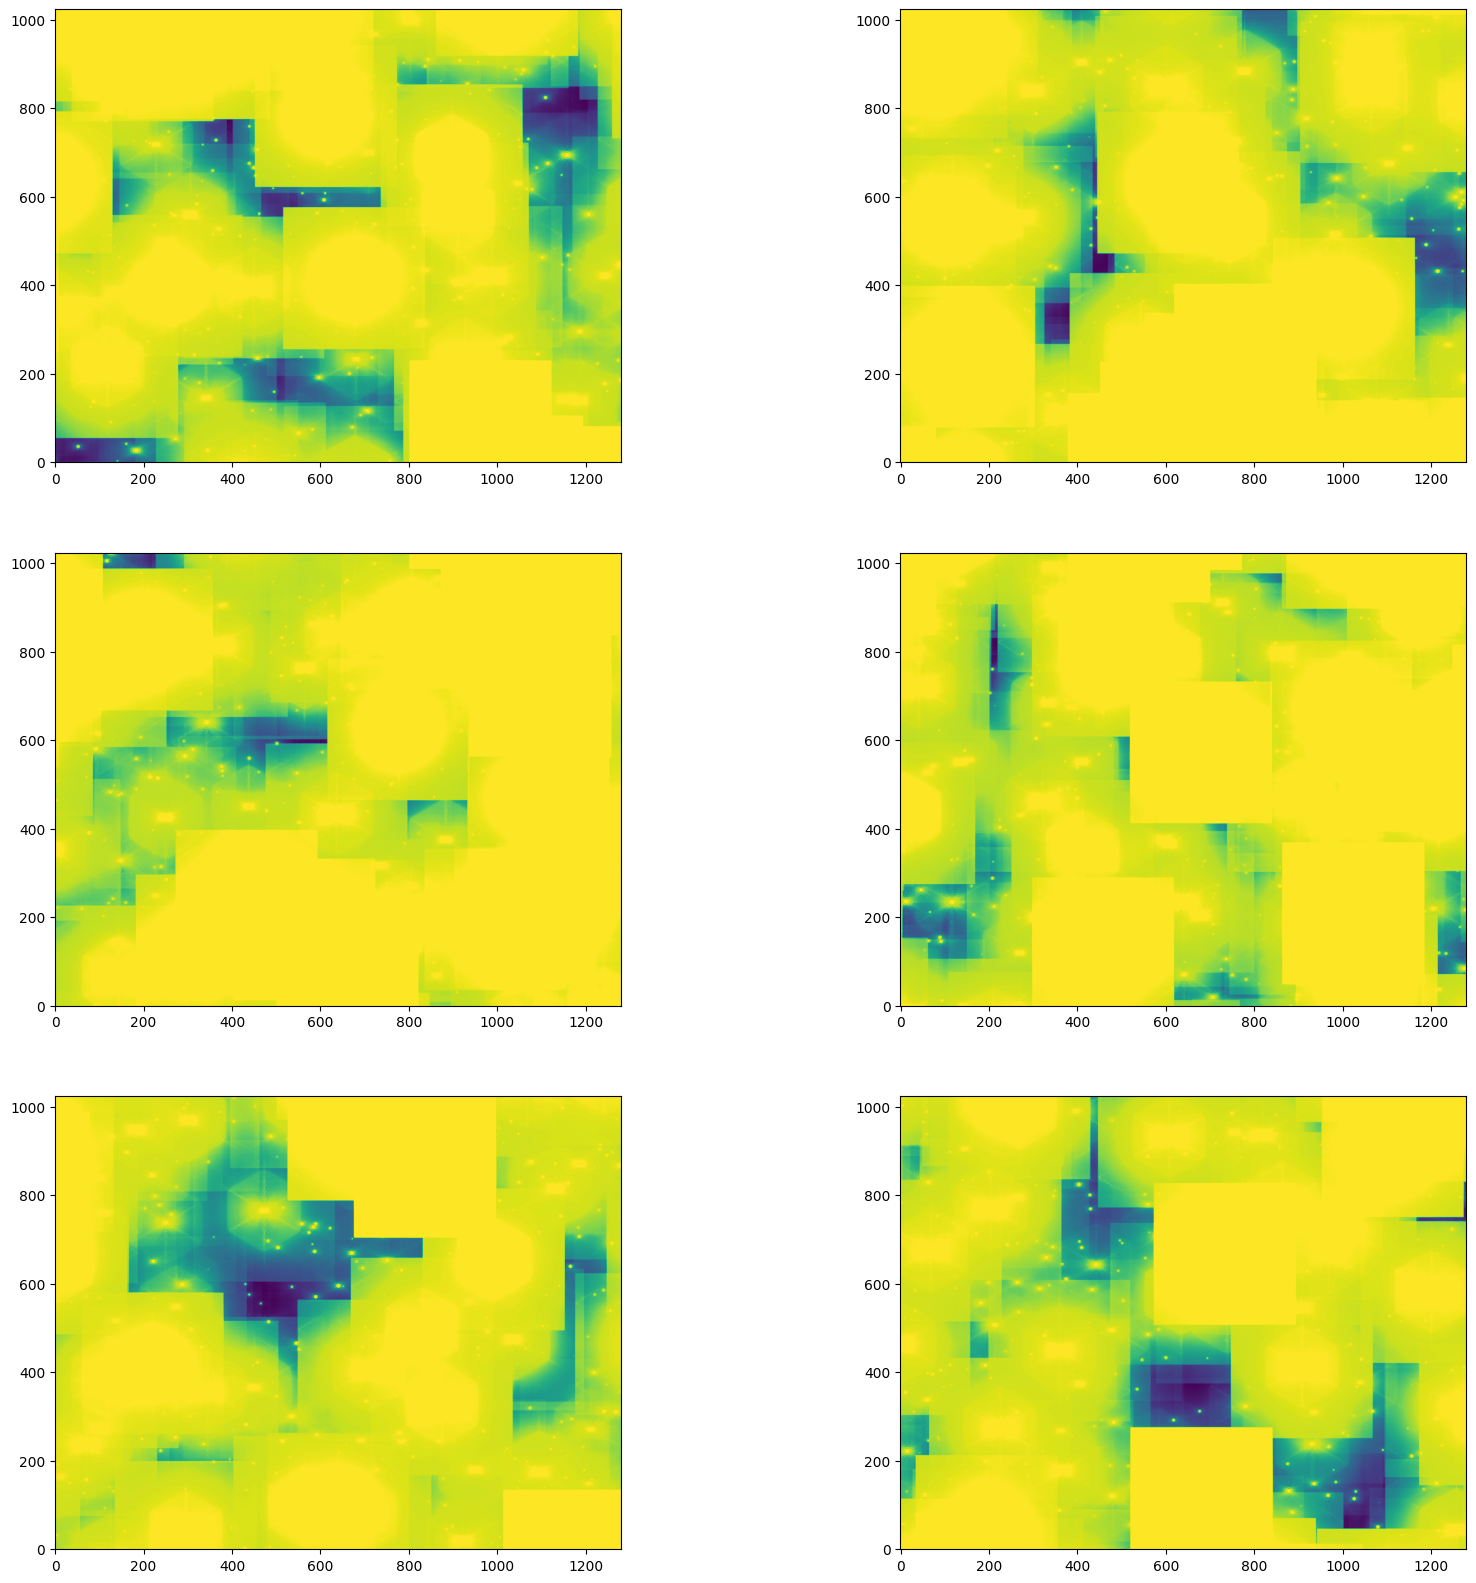

In [31]:
plt.figure(figsize=(20, 20))
for plot_number, hdu_number in enumerate([2, 1, 4, 3, 6, 5], 1):
    plt.subplot(3, 2, plot_number)
    plt.imshow(hdus[0][hdu_number].data, origin="lower", norm=LogNorm())

plt.savefig("MICADO_with_DREAMS_detector_array.png")

In [6]:
hdus[0][0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
MJD-OBS = '2022-01-01T02:30:00'                                                 
RA      =                  0.0                                                  
DEC     =                  0.0                                                  
INSTRUME= ''                                                                    
HIERARCH ESO DPR CATG = 'SCIENCE '                                              
HIERARCH ESO DPR TYPE = 'OBJECT  '                                              
HIERARCH ESO DPR TECH = 'IMAGE   '                                              
HIERARCH ESO DET DIT = 3600                                                     
HIERARCH ESO DET NDIT = 1   

In [7]:
hdus[0].writeto("my_dithered_cluster.fits", overwrite=True)